In [1]:
import sys
sys.path.append('../../../')

In [2]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

c:\Users\vibal\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [4]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [5]:
sets_lengths = (0.6, 0.15, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [6]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [7]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 30/30 [01:45<00:00,  3.51s/it]


#### Results

In [8]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 512/512 [00:16<00:00, 31.36it/s]


In [9]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.3654127433397791,
 'epoch': 49,
 'train_loss': 0.038628444,
 'val_loss': 0.040835936,
 'train_acc': 0.4955555498600006,
 'val_acc': 0.4977777302265167,
 'val_rmse_perc': 0.19914956,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.50_2023-03-31_03.26.11.961394',
 'train_rmse': 0.8366600265340756,
 'val_rmse': 0.8219218670625302,
 'test_rmse': 0.8326663997864531,
 'train_mae': 0.5688888888888889,
 'val_mae': 0.56,
 'test_mae': 0.5653333333333334,
 'train_mcc': 0.3408728141747431,
 'test_mcc': 0.34580920987011987,
 'test_acc': 0.4986666738986969,
 'train_rmse_perc': 0.19476107,
 '

In [10]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.37054695820428524,
 'epoch': 57,
 'train_loss': 0.03803584,
 'val_loss': 0.039797753,
 'train_acc': 0.46000000834465027,
 'val_acc': 0.47555550932884216,
 'val_rmse_perc': 0.1971893,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.48_2023-03-31_03.26.11.961394',
 'train_rmse': 0.8504900548115383,
 'val_rmse': 0.8273115763993905,
 'test_rmse': 0.8516650358758033,
 'train_mae': 0.6011111111111112,
 'val_mae': 0.5777777777777777,
 'test_mae': 0.5973333333333334,
 'train_mcc': 0.30777554745697594,
 'test_mcc': 0.3147347463761463,
 'test_acc': 0.46666666865348816,
 'train_rmse_perc'

In [11]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.3242966373464316,
 'epoch': 100,
 'train_loss': 0.037680436,
 'val_loss': 0.04012714,
 'train_acc': 0.4566666781902313,
 'val_acc': 0.457777738571167,
 'val_rmse_perc': 0.19872667,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.46_2023-03-31_03.26.11.961394_100',
 'train_rmse': 0.8366600265340756,
 'val_rmse': 0.8459051693633013,
 'test_rmse': 0.8262364471909156,
 'train_mae': 0.5955555555555555,
 'val_mae': 0.6,
 'test_mae': 0.5866666666666667,
 'train_mcc': 0.29239849193174466,
 'test_mcc': 0.29740389289446734,
 'test_acc': 0.46133333444595337,
 'train_rmse_perc': 0.19324306

In [12]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 512/512 [00:00<00:00, 29983.58it/s]


In [13]:
cm = all[sort_idx[0]]['test_cm'][0]

In [14]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

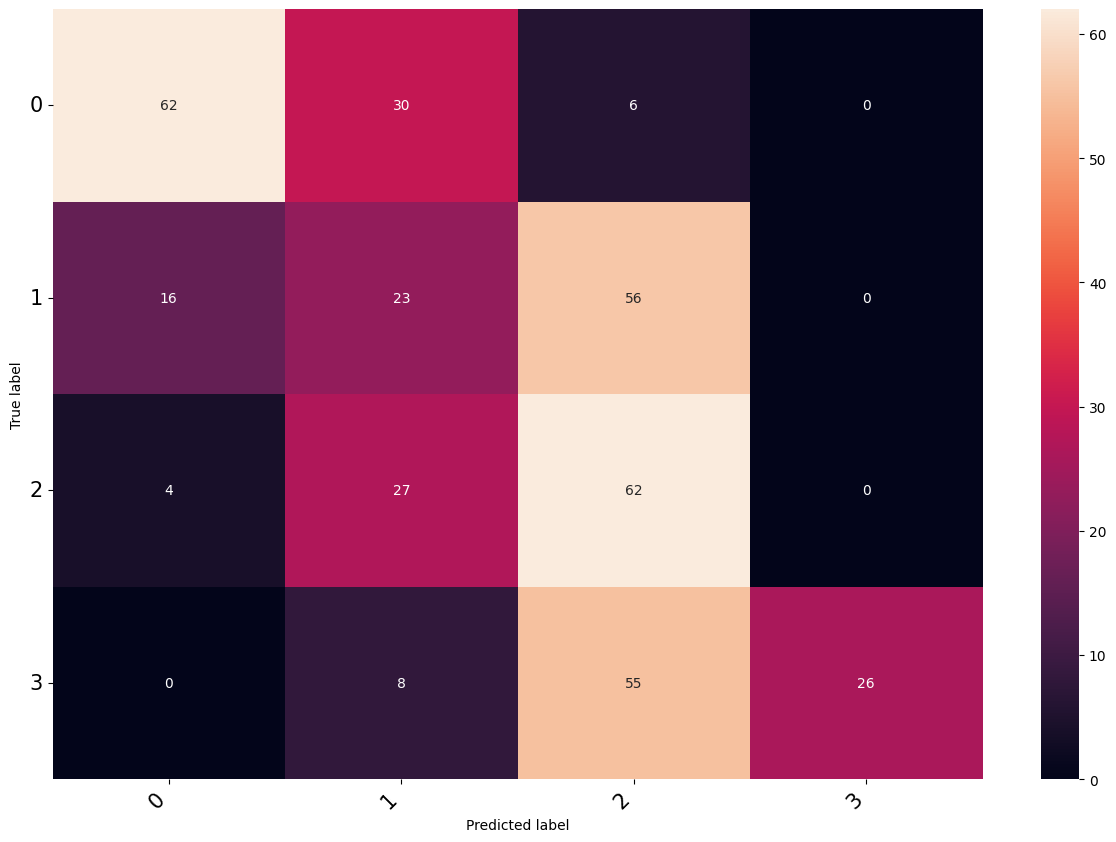

In [15]:
cm.visualize()

In [16]:
cm.class_accuracy

tensor([0.6327, 0.2421, 0.6667, 0.2921])

In [17]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.17599513, 0.19236298, 0.16711493, 0.21279137]

In [18]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.14964464, 0.17056371, 0.13369206, 0.18819693]

### GCN

In [19]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [20]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [07:08<00:00,  5.95s/it]


#### Results

In [21]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1227/1227 [01:22<00:00, 14.93it/s]


In [22]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5757695317630739,
 'epoch': 100,
 'train_loss': 0.023910522,
 'val_loss': 0.027527736,
 'train_acc': 0.648888885974884,
 'val_acc': 0.6711110472679138,
 'val_rmse_perc': 0.15626079,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.67_2023-03-31_03.28.10.004854',
 'train_rmse': 0.648074069840786,
 'val_rmse': 0.6633249580710799,
 'test_rmse': 0.7080489625254268,
 'train_mae': 0.37333333333333335,
 'val_mae': 0.36,
 'test_mae': 0.416,
 'train_mcc': 0.5396245428815164,
 'test_mcc': 0.5036212701087672,
 'test_acc': 0.6213333606719971,
 'train_rmse_perc': 0.15063

In [23]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5676989994860647,
 'epoch': 90,
 'train_loss': 0.026969396,
 'val_loss': 0.025781777,
 'train_acc': 0.6255555748939514,
 'val_acc': 0.657777726650238,
 'val_rmse_perc': 0.14968103,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.66_2023-03-31_03.30.26.707802_90',
 'train_rmse': 0.676592771006148,
 'val_rmse': 0.6394442031083626,
 'test_rmse': 0.7192588778272627,
 'train_mae': 0.4,
 'val_mae': 0.36444444444444446,
 'test_mae': 0.44266666666666665,
 'train_mcc': 0.515281112205468,
 'test_mcc': 0.4659914827198915,
 'test_acc': 0.5893333554267883,
 'train_rmse_

In [24]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5757695317630739,
 'epoch': 100,
 'train_loss': 0.023910522,
 'val_loss': 0.027527736,
 'train_acc': 0.648888885974884,
 'val_acc': 0.6711110472679138,
 'val_rmse_perc': 0.15626079,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.67_2023-03-31_03.28.10.004854_100',
 'train_rmse': 0.648074069840786,
 'val_rmse': 0.6633249580710799,
 'test_rmse': 0.7080489625254268,
 'train_mae': 0.37333333333333335,
 'val_mae': 0.36,
 'test_mae': 0.416,
 'train_mcc': 0.5396245428815164,
 'test_mcc': 0.5036212701087672,
 'test_acc': 0.6213333606719971,
 'train_rmse_perc': 0.1

In [25]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1227/1227 [00:00<00:00, 18613.78it/s]


### GraphSAGE

In [26]:
save_model = f'{save_path}_sage_dist'
log_dir = f'{log_path}_sage_dist'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [27]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 144/144 [1:06:36<00:00, 27.75s/it]


#### Results

In [28]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 4127/4127 [09:04<00:00,  7.58it/s]


In [29]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8521726458031486,
 'epoch': 100,
 'train_loss': 0.002821728,
 'val_loss': 0.0077203913,
 'train_acc': 0.9711111187934875,
 'val_acc': 0.8888888359069824,
 'val_rmse_perc': 0.07287121,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.89_2023-03-31_03.47.02.188045_100',
 'train_rmse': 0.1699673171197595,
 'val_rmse': 0.38873012632302,
 'test_rmse': 0.39665266081716044,
 'train_mae': 0.028888888888888888,
 'val_mae': 0.12444444444444444,
 'test_mae': 0.14133333333333334,
 'train_mcc': 0.9615066759998887,
 'test_mcc': 0.818988

In [30]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8274067257237099,
 'epoch': 100,
 'train_loss': 0.0036951178,
 'val_loss': 0.0062968945,
 'train_acc': 0.9511111378669739,
 'val_acc': 0.8711110353469849,
 'val_rmse_perc': 0.06085968,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.87_2023-03-31_04.06.16.986806_100',
 'train_rmse': 0.22110831935702666,
 'val_rmse': 0.3590109871423003,
 'test_rmse': 0.4472135954999579,
 'train_mae': 0.04888888888888889,
 'val_mae': 0.1288888888888889,
 'test_mae': 0.184,
 'train_mcc': 0.9348955975615103,
 'test_mcc': 0.7631703049984518,


In [31]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.8039343846286789,
 'epoch': 100,
 'train_loss': 0.0039570937,
 'val_loss': 0.007840253,
 'train_acc': 0.9399999976158142,
 'val_acc': 0.8533332943916321,
 'val_rmse_perc': 0.07701361,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.85_2023-03-31_04.23.14.309532',
 'train_rmse': 0.2449489742783178,
 'val_rmse': 0.4,
 'test_rmse': 0.44422216663887154,
 'train_mae': 0.06,
 'val_mae': 0.1511111111111111,
 'test_mae': 0.17066666666666666,
 'train_mcc': 0.9205319083508711,
 'test_mcc': 0.7873519064493351,
 'test_acc': 0.839999

In [32]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 4127/4127 [00:00<00:00, 30283.02it/s]


#### cm

In [33]:
cm = all[sort_idx[0]]['test_cm'][0]

In [34]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

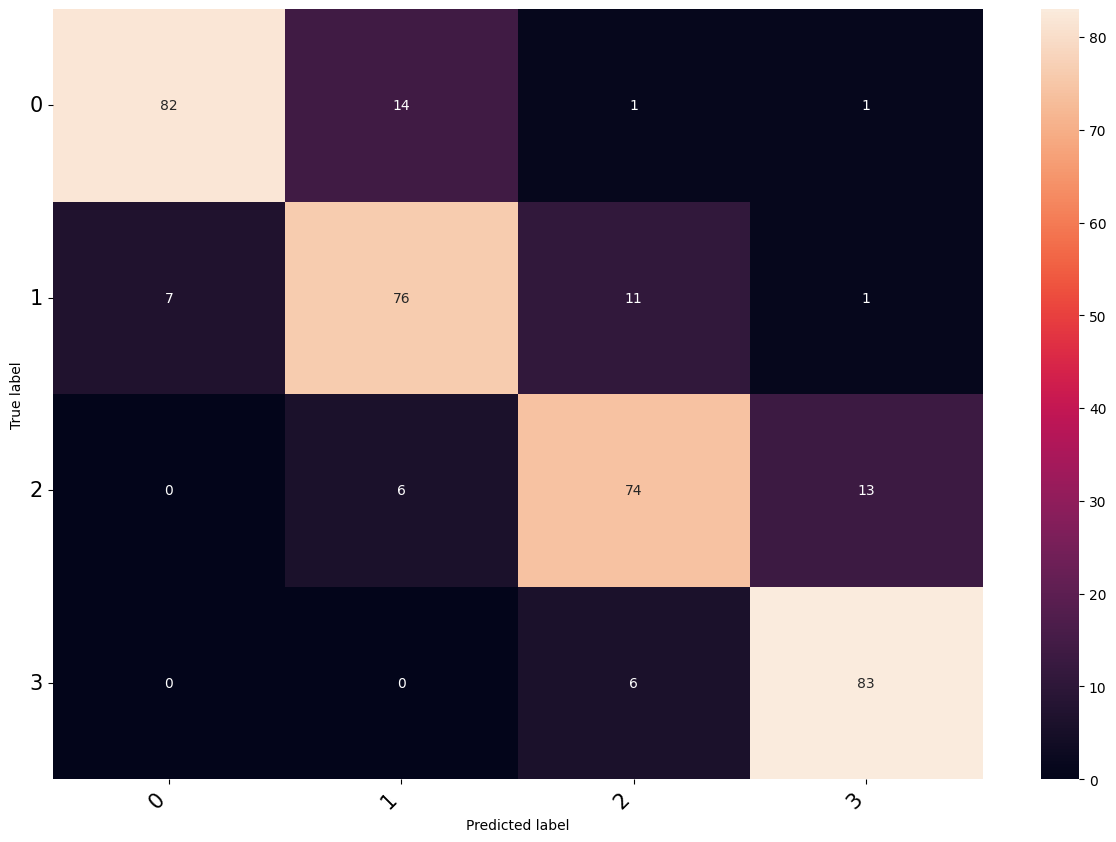

In [35]:
cm.visualize()

In [36]:
cm.class_accuracy

tensor([0.8367, 0.8000, 0.7957, 0.9326])

In [37]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.09378044, 0.07969058, 0.05355306, 0.06421177]

In [38]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.054866605, 0.056097187, 0.041910905, 0.047105033]

#### GraphSAGE Base_n

In [39]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [40]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='base_n',
        )

100%|██████████| 144/144 [59:38<00:00, 24.85s/it] 


##### Results

In [41]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='base_n',
)

100%|██████████| 2973/2973 [06:02<00:00,  8.21it/s]


In [42]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7476726010667785,
 'epoch': 71,
 'train_loss': 0.0035511542,
 'val_loss': 0.013726075,
 'train_acc': 0.8155555725097656,
 'val_acc': 0.7999999523162842,
 'val_rmse_perc': 0.0985322,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.80_2023-03-31_05.00.04.041109',
 'train_rmse': 0.42946995755750417,
 'val_rmse': 0.4472135954999579,
 'test_rmse': 0.5316640543300503,
 'train_mae': 0.18444444444444444,
 'val_mae': 0.2,
 'test_mae': 0.26666666666666666,
 'train_mcc': 0.7653599515174213,
 'test_mcc': 0.6640777646708467,
 'test_

In [43]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7476726010667785,
 'epoch': 71,
 'train_loss': 0.0035511542,
 'val_loss': 0.013726075,
 'train_acc': 0.8155555725097656,
 'val_acc': 0.7999999523162842,
 'val_rmse_perc': 0.0985322,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.80_2023-03-31_05.00.04.041109',
 'train_rmse': 0.42946995755750417,
 'val_rmse': 0.4472135954999579,
 'test_rmse': 0.5316640543300503,
 'train_mae': 0.18444444444444444,
 'val_mae': 0.2,
 'test_mae': 0.26666666666666666,
 'train_mcc': 0.7653599515174213,
 'test_mcc': 0.6640777646708467,
 'test_

In [44]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7476726010667785,
 'epoch': 71,
 'train_loss': 0.0035511542,
 'val_loss': 0.013726075,
 'train_acc': 0.8155555725097656,
 'val_acc': 0.7999999523162842,
 'val_rmse_perc': 0.0985322,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.80_2023-03-31_05.00.04.041109',
 'train_rmse': 0.42946995755750417,
 'val_rmse': 0.4472135954999579,
 'test_rmse': 0.5316640543300503,
 'train_mae': 0.18444444444444444,
 'val_mae': 0.2,
 'test_mae': 0.26666666666666666,
 'train_mcc': 0.7653599515174213,
 'test_mcc': 0.6640777646708467,
 'test_

In [45]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2973/2973 [00:00<00:00, 28124.93it/s]


##### cm

In [46]:
cm = all[sort_idx[0]]['test_cm'][0]

In [47]:
(cm.labels==0).sum()

tensor(98)

In [48]:
cm.perc.max()

tensor(0.9986)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

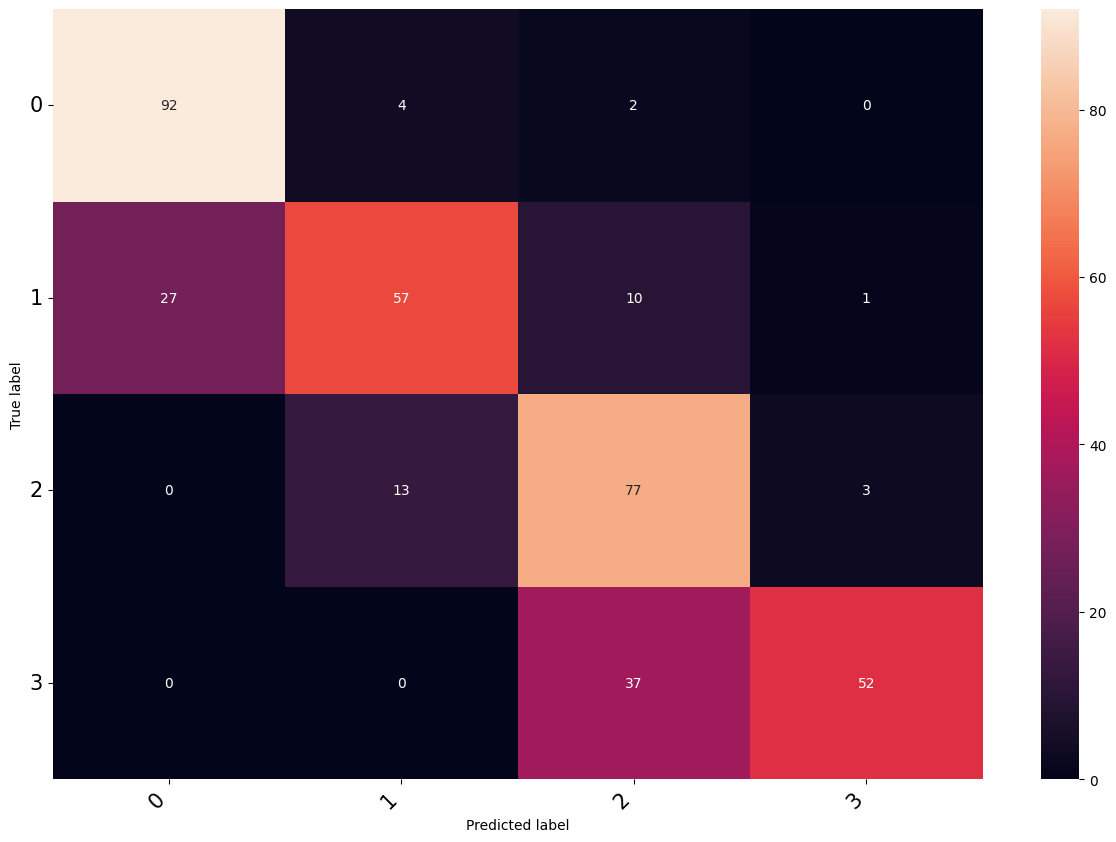

In [49]:
cm.visualize()

In [50]:
cm.class_accuracy

tensor([0.9388, 0.6000, 0.8280, 0.5843])

In [51]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.114956714, 0.11894281, 0.075429484, 0.13965939]

In [52]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08490146, 0.08781, 0.059777725, 0.12346801]

#### GraphSAGE Scale

In [53]:
save_model = f'{save_path}_sage_scale'
log_dir = f'{log_path}_sage_scale'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [54]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='scale',
        )

100%|██████████| 144/144 [59:20<00:00, 24.72s/it] 


##### Results

In [55]:
res_edges_sage_dist = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='scale',
)

100%|██████████| 4154/4154 [08:35<00:00,  8.06it/s]


In [56]:
res_edges = res_edges_sage_dist
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7833636983729316,
 'epoch': 90,
 'train_loss': 0.0045344047,
 'val_loss': 0.014487512,
 'train_acc': 0.9344444274902344,
 'val_acc': 0.8355554938316345,
 'val_rmse_perc': 0.10811863,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.84_2023-03-31_06.55.57.056748_90',
 'train_rmse': 0.2560381915956203,
 'val_rmse': 0.43716256828680006,
 'test_rmse': 0.4979959839195493,
 'train_mae': 0.06555555555555556,
 'val_mae': 0.17333333333333334,
 'test_mae': 0.19466666666666665,
 'train_mcc': 0.9150991407288697,
 'test_mcc': 0.77426

In [57]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.7943747390683861,
 'epoch': 100,
 'train_loss': 0.02251551,
 'val_loss': 0.011989775,
 'train_acc': 0.8422222137451172,
 'val_acc': 0.8444443941116333,
 'val_rmse_perc': 0.08097541,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.84_2023-03-31_06.13.03.869481_100',
 'train_rmse': 0.39721250959376614,
 'val_rmse': 0.39440531887330776,
 'test_rmse': 0.48716869083853626,
 'train_mae': 0.15777777777777777,
 'val_mae': 0.15555555555555556,
 'test_mae': 0.21066666666666667,
 'train_mcc': 0.796283305100663,
 'test_mcc': 0.7

In [58]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.811159373579835,
 'epoch': 68,
 'train_loss': 0.020981455,
 'val_loss': 0.014438559,
 'train_acc': 0.8600000143051147,
 'val_acc': 0.8577777147293091,
 'val_rmse_perc': 0.08210671,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.86_2023-03-31_06.51.06.063771',
 'train_rmse': 0.37416573867739417,
 'val_rmse': 0.37712361663282534,
 'test_rmse': 0.48166378315169184,
 'train_mae': 0.14,
 'val_mae': 0.14222222222222222,
 'test_mae': 0.20533333333333334,
 'train_mcc': 0.8184977431067929,
 'test_mcc': 0.7441610495149474,
 '

In [59]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 4154/4154 [00:00<00:00, 30564.82it/s]


##### cm

In [60]:
cm = all[sort_idx[0]]['test_cm'][0]

In [61]:
(cm.labels==0).sum()

tensor(98)

In [62]:
cm.perc.max()

tensor(0.9987)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

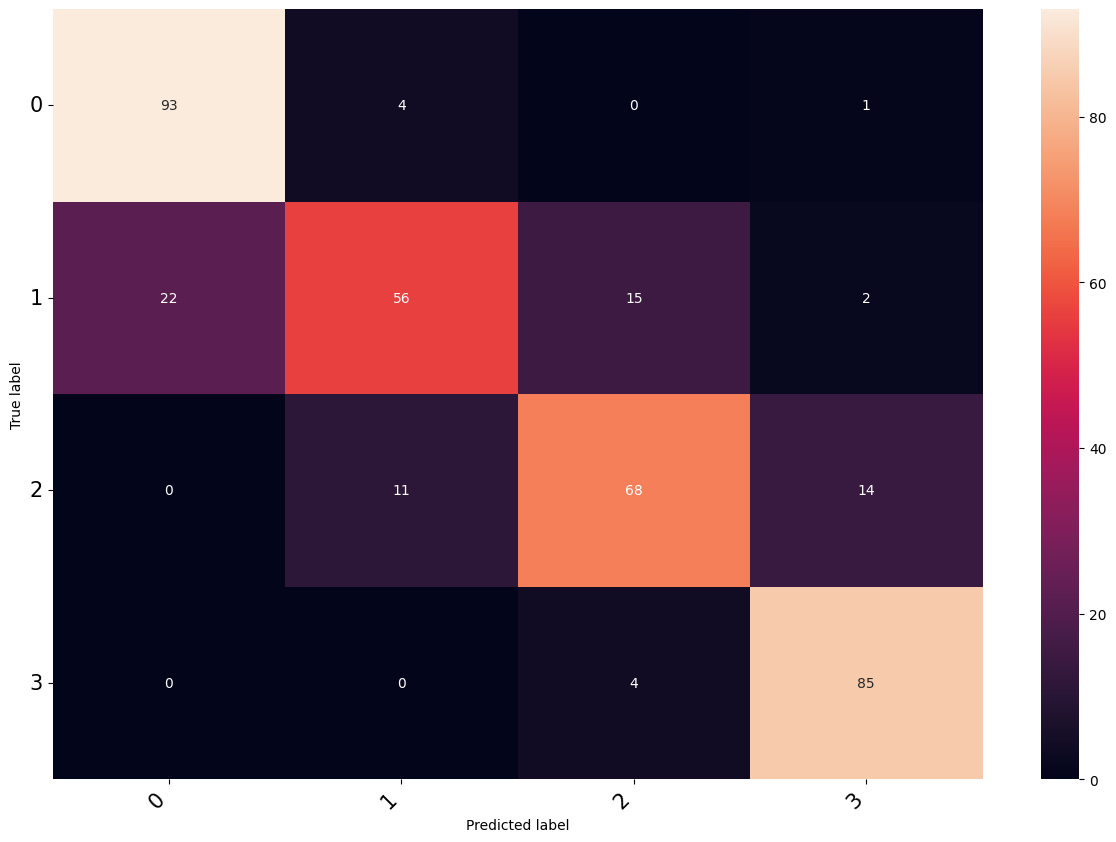

In [63]:
cm.visualize()

In [64]:
cm.class_accuracy

tensor([0.9490, 0.5895, 0.7312, 0.9551])

In [65]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.09921537, 0.12425664, 0.08530331, 0.058624234]

In [66]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07412166, 0.09615984, 0.067601725, 0.04772008]

### GAT

In [67]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [68]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 288/288 [24:41<00:00,  5.14s/it]


#### Results

In [69]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 4958/4958 [02:54<00:00, 28.39it/s]


In [70]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4565308208485304,
 'epoch': 89,
 'train_loss': 0.04206028,
 'val_loss': 0.032786656,
 'train_acc': 0.597777783870697,
 'val_acc': 0.5777777433395386,
 'val_rmse_perc': 0.16987495,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.58_2023-03-31_07.23.45.568100',
 'train_rmse': 0.6871842709362768,
 'val_rmse': 0.7542472332656507,
 'test_rmse': 0.7882470002057308,
 'train_mae': 0.4255555555555556,
 'val_mae': 0.4711111111111111,
 'test_mae': 0.5093333333333333,
 'train_mcc': 0.47384063862140685,
 'test

In [71]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.47098367223720233,
 'epoch': 100,
 'train_loss': 0.036250204,
 'val_loss': 0.02912499,
 'train_acc': 0.5955555438995361,
 'val_acc': 0.5866666436195374,
 'val_rmse_perc': 0.1588115,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.59_2023-03-31_07.14.05.221182_100',
 'train_rmse': 0.6839428176227731,
 'val_rmse': 0.7180219742846006,
 'test_rmse': 0.7694153624668538,
 'train_mae': 0.4255555555555556,
 'val_mae': 0.4444444444444444,
 'test_mae': 0.5173333333333333,
 'train_mcc': 0.4755716791152981,
 'tes

In [72]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.47098367223720233,
 'epoch': 100,
 'train_loss': 0.036250204,
 'val_loss': 0.02912499,
 'train_acc': 0.5955555438995361,
 'val_acc': 0.5866666436195374,
 'val_rmse_perc': 0.1588115,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.59_2023-03-31_07.14.05.221182_100',
 'train_rmse': 0.6839428176227731,
 'val_rmse': 0.7180219742846006,
 'test_rmse': 0.7694153624668538,
 'train_mae': 0.4255555555555556,
 'val_mae': 0.4444444444444444,
 'test_mae': 0.5173333333333333,
 'train_mcc': 0.4755716791152981,
 'tes

In [73]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 4958/4958 [00:00<00:00, 30605.08it/s]
